In [1]:
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

%tensorflow_version 2.x
import tensorflow as tf

import numpy as np
import base64, io, time, gym
import IPython, functools
import matplotlib.pyplot as plt
from tqdm import tqdm

!pip install mitdeeplearning
import mitdeeplearning as mdl

Reinforcement learning problems in general:
1. Initialize our environment and our agent: here we will describe the different observations and actions the agent can make in the environment.
2. Define our agent's memory: this will enable the agent to remember its past actions, observations, and rewards.
3. Define a reward function: describes the reward associated with an action or sequence of actions.
4. Define the learning algorithm: this will be used to reinforce the agent's good behaviors and discourage bad behaviors.

# Cartpole

In [2]:
env = gym.make("CartPole-v0")
env.seed(1) # initialize a same random env every time

[1]

First, let's consider the observation space. In this Cartpole environment our observations are:
1. Cart position
2. Cart velocity
3. Pole angle
4. Pole rotation rate

In [3]:
# confirm by querying the environment
n_observations = env.observation_space
print("Environment has observation space =", n_observations)

Environment has observation space = Box(4,)


In [4]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Number of possible actions that the agent can choose from = 2


In [5]:
# define the agent
def create_cartpole_model():
    model = tf.keras.models.Sequential([
                                        tf.keras.layers.Dense(units=32, activation='relu'),
                                        tf.keras.layers.Dense(units=n_actions, activation=None)
    ])
    return model

cartpole_model = create_cartpole_model()

In [6]:
# define the agent action function
def choose_action(model, observation):
    observation = np.expand_dims(observation, axis=0)
    logits = model.predict(observation)

    prob_weights = tf.nn.softmax(logits).numpy()
    # print("Check dimensions: ", observation.shape, logits.shape, prob_weights.shape)
    action = np.random.choice(n_actions, size=1, p=prob_weights.flatten())[0]
    # print("What action did it choose?", action)
    return action

In [7]:
# agent memory 
class Memory:
    def __init__(self):
        self.clear()
    
    def clear(self):
        # reset memory buffer
        self.observations = []
        self.actions = []
        self.rewards = []

    def add_to_memory(self, new_observation, new_action, new_reward):
        self.observations.append(new_observation)
        self.actions.append(new_action)
        self.rewards.append(new_reward)
        
memory = Memory()

In [9]:
# reward function
def normalize(x):
    x -= np.mean(x)
    x /= np.std(x)
    return x.astype(np.float32)

def discount_rewards(rewards, gamma=0.95):
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))): # prefer to get reward now instead of long term
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R

    return normalize(discounted_rewards)

Now define the learning steps

In [8]:
# loss 
def compute_loss(logits, actions, rewards):
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions)
    loss = tf.reduce_mean(neg_logprob * rewards)
    return loss

In [10]:
# training step
def train_step(model, optimizer, observations, actions, discounted_rewards):
    with tf.GradientTape() as tape:
        logits = model(observations)
        loss = compute_loss(logits, actions, discounted_rewards)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

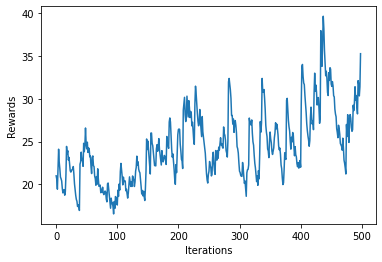

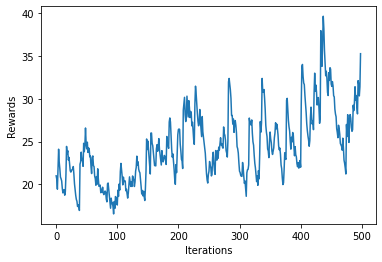

In [12]:
# start training!

learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)
cartpole_model = create_cartpole_model()

smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.9)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel="Iterations", ylabel='Rewards')

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for i_episode in range(500):
    plotter.plot(smoothed_reward.get())
    observation = env.reset()
    memory.clear()

    while True:
        action = choose_action(cartpole_model, observation)
        next_observation, reward, done, info = env.step(action)
        memory.add_to_memory(next_observation, action, reward)

        if done:
            total_reward = sum(memory.rewards)
            smoothed_reward.append(total_reward)

            train_step(
                cartpole_model,
                optimizer,
                observations = np.vstack(memory.observations),
                actions = np.array(memory.actions),
                discounted_rewards = discount_rewards(memory.rewards)
            )
            memory.clear()
            break
        observation = next_observation

In [13]:
# display the learning result
saved_cartpole = mdl.lab3.save_video_of_model(cartpole_model, "CartPole-v0")
mdl.lab3.play_video(saved_cartpole)

Successfully saved 79 frames into CartPole-v0.mp4!


# Pong

In [11]:
env = gym.make("Pong-v0", frameskip=5)
env.seed(1)
print("Environment has observation space=", env.observation_space)
n_actions = env.action_space.n
print("Number of actions that agent can choose from =", n_actions)

Environment has observation space= Box(210, 160, 3)
Number of actions that agent can choose from = 6


In [12]:
# pong agent
Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
Flatten = tf.keras.layers.Flatten
Dense = tf.keras.layers.Dense

def create_pong_model():
    model = tf.keras.models.Sequential([
                                        Conv2D(filters=16, kernel_size=7, strides=4),
                                        Conv2D(filters=32, kernel_size=5, strides=2),
                                        Conv2D(filters=48, kernel_size=3, strides=2),
                                        Flatten(),
                                        Dense(units=64, activation='relu'),
                                        Dense(units=n_actions, activation=None)
    ])
    return model

pong_model = create_pong_model()

In [13]:
# Pong reward function
def discount_rewards(rewards, gamma=0.99):
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):
        # reset the rewards to 0 in two cases: win (1), lose (-1)
        if rewards[t] != 0:
            R = 0
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R
    
    return normalize(discounted_rewards)

Text(0.5, 1.0, 'Preprocessed Observation')

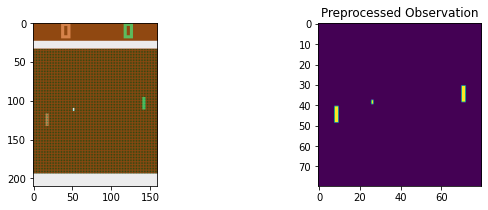

In [14]:
observation = env.reset()
for i in range(30):
    observation, _, _, _ = env.step(0)

observation_pp = mdl.lab3.preprocess_pong(observation)

f = plt.figure(figsize=(10, 3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(observation)
ax.grid(False)
ax2.imshow(np.squeeze(observation_pp))
ax2.grid(False)
plt.title("Preprocessed Observation")

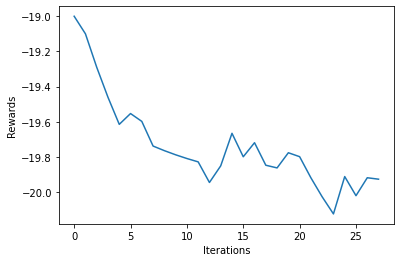

In [ ]:
# training pong
learning_rate = 1e-4
MAX_ITER = 10000
pong_model = create_pong_model()
optimizer = tf.keras.optimizers.Adam(learning_rate)

# plotting
smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.9)
plotter = mdl.util.PeriodicPlotter(sec=5, xlabel='Iterations', ylabel='Rewards')
memory = Memory()

for i_episode in range(MAX_ITER):
    plotter.plot(smoothed_reward.get())

    observation = env.reset()
    previous_frame = mdl.lab3.preprocess_pong(observation)

    while True:
        current_frame = mdl.lab3.preprocess_pong(observation)
        obs_change = current_frame - previous_frame
        action = choose_action(pong_model, obs_change)
        next_observation, reward, done, info = env.step(action)
        memory.add_to_memory(obs_change, action, reward)

        if done:
            total_reward = sum(memory.rewards)
            smoothed_reward.append(total_reward)

            train_step(
                pong_model,
                optimizer,
                np.stack(memory.observations, 0),
                np.array(memory.actions),
                discount_rewards(memory.rewards)
            )
            memory.clear()
            break
        observation = next_observation
        previous_frame = current_frame

In [ ]:
saved_pong = mdl.lab3.save_video_of_model(
    pong_model, "Pong-v0", obs_diff=True, 
    pp_fn=mdl.lab3.preprocess_pong)
mdl.lab3.play_video(saved_pong)